# Genrenator

In [239]:
import librosa as lr
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import SGD

import os



# Example of the audio wave and mel spectrum of a song
#### We are using the librosa library because of it's audio processing capabilities

In [2]:
y_hip, sampling_rate_hip = lr.load('./hiphop.00000.wav')

In [3]:
y_hip.shape

(661504,)

In [4]:
sampling_rate_hip 

22050

C:\Users\joeyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


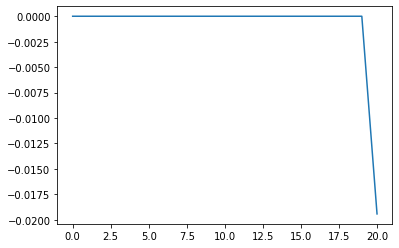

In [5]:
plt.plot(np.polyfit(range(len(y_hip)), y_hip, 20))

#### Waveform Visualizations for a Hip Hop Track

Text(0, 0.5, 'Amplitude')

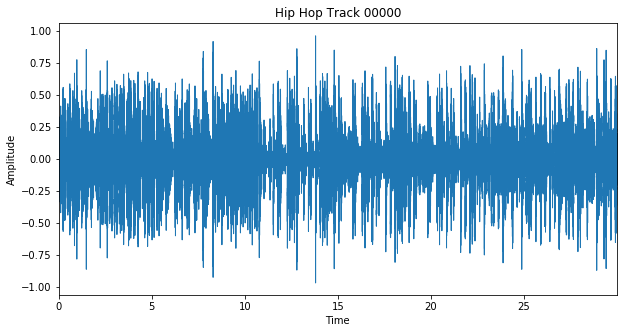

In [6]:
# Audio Wave
plt.figure(figsize=(10, 5))
lr.display.waveplot(y_hip, sr=sampling_rate_hip)
plt.title('Hip Hop Track 00000')
plt.xlabel('Time')
plt.ylabel('Amplitude')

#### Mel Spectrogram Visualization for a Hip Hop Track

Text(0.5, 1.0, 'Hip Hop')

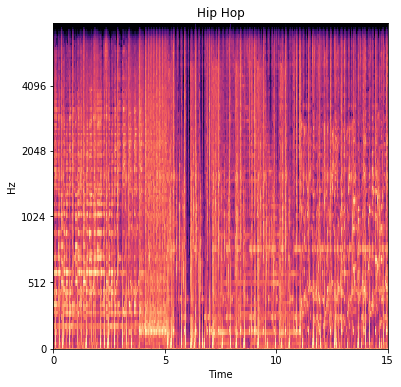

In [7]:
# Mel Spectrum
mel_spectrum_hip = lr.feature.melspectrogram(y=y_hip, sr=sampling_rate_hip, n_fft=2048, hop_length=1024) # n_fft/hop_length may need tweaking
mel_spectrum_hip = lr.power_to_db(mel_spectrum_hip, ref=np.max)

# Plot the Mel Spectrogram for HipHop audio 000000
plt.figure(figsize=(6, 6))
lr.display.specshow(mel_spectrum_hip, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Hip Hop')

In [8]:
mel_spectrum_hip.shape

(128, 647)

# Extracting Data
#### This dataset includes various audio features which have been extracted from the 30 second audio files which are 100 each for every genre. Some of the features include chroma mean, spectral centroid mean, rollof mean, and mfcc means.

In [9]:
DIR = './combined_wav' # directory where all wav files are

In [271]:
genre_map = ['hiphop', 'reggae', 'pop', 'blues', 'country','jazz', 'metal','disco','classical', 'rock']

In [77]:
data = pd.read_csv('features_30_sec.csv')
data = data.loc[data['filename'] != 'jazz.00054.wav']
data.drop(['filename', 'length', 'perceptr_mean', 'perceptr_var'], axis=1, inplace=True)
data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [12]:
metadata = pd.DataFrame(columns=['min', 'dif'], index=data.columns[:-1])

for index in data.columns[:-1]:
    metadata.loc[index, 'min'] = data[index].min()
    metadata.loc[index, 'dif'] = data[index].max() - data[index].min()
    data[index] = (data[index] - data[index].min()) / (data[index].max() - data[index].min())

metadata

,min,dif
chroma_stft_mean,0.171939,0.491745
chroma_stft_var,0.0445552,0.0635562
rms_mean,0.00527644,0.392697
rms_var,4.29437e-06,0.0276752
spectral_centroid_mean,570.04,3865.2
spectral_centroid_var,7911.25,3.02893e+06
spectral_bandwidth_mean,898.066,2611.58
spectral_bandwidth_var,10787.2,683998
rolloff_mean,749.141,7928.53
rolloff_var,14686.1,8.64621e+06


In [13]:
data

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.362279,0.695468,0.318188,0.101983,0.314117,0.040233,0.422879,0.109789,0.385532,0.102567,...,0.112704,0.541287,0.057615,0.422444,0.082450,0.487950,0.109503,0.599189,0.078255,blues
1,0.343622,0.793392,0.230894,0.085580,0.248405,0.121475,0.436889,0.296867,0.353329,0.342717,...,0.120353,0.574685,0.118286,0.448184,0.102997,0.548800,0.099081,0.579640,0.075947,blues
2,0.389832,0.640692,0.433652,0.099064,0.254261,0.049046,0.325334,0.095712,0.289224,0.088981,...,0.081898,0.331003,0.085962,0.370988,0.116420,0.453724,0.087317,0.501381,0.045405,blues
3,0.473508,0.777954,0.345856,0.229160,0.129376,0.058253,0.267404,0.227566,0.181068,0.171001,...,0.091876,0.484549,0.092509,0.460684,0.068975,0.538690,0.062612,0.468060,0.048168,blues
4,0.277759,0.681062,0.219641,0.083075,0.327270,0.110761,0.325514,0.113536,0.357017,0.180228,...,0.200462,0.410225,0.156424,0.403875,0.120300,0.424652,0.130173,0.233047,0.094836,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.366294,0.565355,0.188974,0.012317,0.372066,0.090548,0.462737,0.113776,0.442001,0.139684,...,0.093498,0.137363,0.070955,0.528217,0.067274,0.355114,0.108986,0.530772,0.084307,rock
996,0.461109,0.480368,0.181264,0.021099,0.371728,0.057513,0.448340,0.104735,0.428856,0.119351,...,0.064317,0.222386,0.064937,0.506174,0.052253,0.332575,0.067713,0.485401,0.047815,rock
997,0.529141,0.483246,0.194487,0.011492,0.390015,0.073870,0.394101,0.093465,0.413981,0.091315,...,0.063653,0.152848,0.057215,0.563199,0.064824,0.178146,0.076420,0.504920,0.043984,rock
998,0.387488,0.738721,0.200112,0.043603,0.214389,0.076729,0.352424,0.143718,0.285865,0.152440,...,0.096819,0.446369,0.075619,0.494291,0.059564,0.405462,0.088864,0.462871,0.066938,rock


#### One Hot Encoding

In [78]:
y = data['label']
data.drop('label', axis=1, inplace=True)
y = pd.get_dummies(y, columns=['label'])
y

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,1
996,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,0,0,1
998,0,0,0,0,0,0,0,0,0,1


#### We split the data with a train test ratio of 85:15

In [15]:
# split training set and test set (validation set will be during model training) -> 70-15-15 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)

In [16]:
X_train

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
939,0.550389,0.443432,0.354234,0.053283,0.514616,0.075699,0.701846,0.121495,0.592517,0.212437,...,0.617033,0.023154,0.545227,0.008375,0.296425,0.012536,0.372278,0.013341,0.412206,0.018518
552,0.395120,0.743354,0.466404,0.165002,0.444876,0.120561,0.648814,0.200580,0.566875,0.224448,...,0.670609,0.131441,0.589696,0.101171,0.445846,0.176318,0.610343,0.168539,0.611763,0.087781
120,0.197468,0.630328,0.084498,0.018523,0.167656,0.032440,0.174400,0.099670,0.194921,0.052599,...,0.560507,0.212847,0.650633,0.112769,0.429065,0.128620,0.518318,0.219334,0.363524,0.170146
263,0.329352,0.818307,0.321368,0.087477,0.270285,0.196021,0.428446,0.469270,0.367118,0.418285,...,0.581401,0.170936,0.393026,0.168132,0.696116,0.431016,0.492097,0.270801,0.703196,0.416947
526,0.060760,0.799233,0.067965,0.011243,0.206273,0.136845,0.283583,0.329219,0.237388,0.295946,...,0.745055,0.963461,0.782566,0.695633,0.526056,0.638346,0.786886,0.755038,0.842960,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,0.306532,0.714846,0.362220,0.135901,0.366888,0.360049,0.644183,0.592323,0.443697,0.759532,...,0.285641,0.293260,0.511060,0.249008,0.374830,0.268665,0.372301,0.275880,0.708216,0.248949
556,0.408207,0.690754,0.491705,0.077349,0.622556,0.086475,0.818625,0.076597,0.770843,0.113207,...,0.693454,0.084344,0.603071,0.050277,0.363276,0.071861,0.440852,0.129415,0.504686,0.107053
373,0.557986,0.496202,0.229899,0.062203,0.589176,0.101449,0.598148,0.060548,0.652908,0.085818,...,0.712714,0.036338,0.243912,0.037618,0.612727,0.034148,0.376167,0.048406,0.557901,0.044827
995,0.366294,0.565355,0.188974,0.012317,0.372066,0.090548,0.462737,0.113776,0.442001,0.139684,...,0.599764,0.093498,0.137363,0.070955,0.528217,0.067274,0.355114,0.108986,0.530772,0.084307


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU, Input

In [66]:
stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=True)
slower = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=True)

# Version 1 of potential model

#### We are using a deep learning neural network with 3 layers using selu activation and leakyReLu. Selu gives us much better results compared to other activation functions. We also added 2 dropout layers one of 0.5 and one of 0.1, We used an Adam optimizer with categorical crossentropy loss.

#### Our model gives us a 64% accuracy, which is better than our CNN models.

accuracy = 0.653

model_new = Sequential()
model_new.add(Dense(X_train.shape[1], activation='selu'))

model_new.add(Dense(128))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.5))
model_new.add(Dense(64))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.1))
model_new.add(Dense(10, activation='softmax'))

model_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Version 1 of potential model

model_new = Sequential()
model_new.add(Input((X_train.shape[1],)))
model_new.add(Dense(64, activation='selu'))

model_new.add(Dense(128))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.5))
model_new.add(Dense(64))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.1))
model_new.add(Dense(10, activation='softmax'))

model_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Batch size might change -> 70-15-15 split between train-test-validation sets validation_data=(X_test, y_test),
history = model_new.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.15, callbacks=[slower, stopper])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
88/91 [============================>.] - ETA: 0s - loss: 2.2039 - accuracy: 0.1889WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000261D9E6FEE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

91/91 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.7853 - val_loss: 0.9653 - val_accuracy: 0.6953


In [21]:
test_accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test Set Loss: ',test_accuracy[0])
print('Test Set Accuracy: ',test_accuracy[1])

Test Set Loss:  0.9372298121452332
Test Set Accuracy:  0.6399999856948853


In [22]:
# model_new.save('new_model_3.h5')

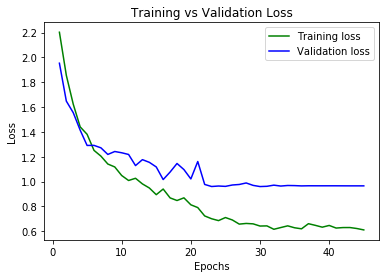

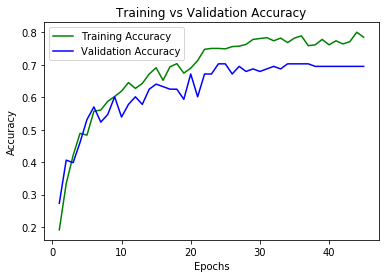

In [23]:
# Training and validation Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy for training and validation
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

epochs = range(1,len(accuracy_train)+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')


plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
model_new = Sequential()
model_new.add(Input((X_train.shape[1],)))
model_new.add(Dense(64, activation='selu'))

model_new.add(Dense(128))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.5))
model_new.add(Dense(64))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.1))
model_new.add(Dense(10, activation='softmax'))

model_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_new.fit(X, y, epochs=100, batch_size=8, validation_split=0.15, callbacks=[slower, stopper])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 88/107 [=======================>......] - ETA: 0s - loss: 2.0864 - accuracy: 0.2259WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000261DE1655E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

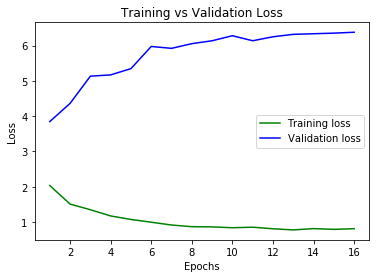

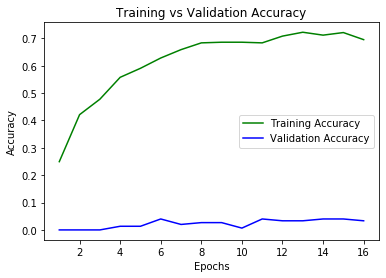

In [25]:
# Training and validation Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy for training and validation
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

epochs = range(1,len(accuracy_train)+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')


plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
sample_size = 30*20_000

full_features = []
check = 0

for audio in os.scandir(DIR):
    print(audio)
    check += 1
    y_data, sample_rate = lr.load(audio)

    cur_data = y_data
    
    features = []

    c_s = lr.feature.chroma_stft(cur_data)
    features.append(np.mean(c_s))
    features.append(np.var(c_s))

    rms = lr.feature.rms(cur_data)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    s_c = lr.feature.spectral_centroid(cur_data)
    features.append(np.mean(s_c))
    features.append(np.var(s_c))

    s_b = lr.feature.spectral_bandwidth(cur_data)
    features.append(np.mean(s_b))
    features.append(np.var(s_b))

    s_r = lr.feature.spectral_rolloff(cur_data)
    features.append(np.mean(s_r))
    features.append(np.var(s_r))

    z_c_r = lr.feature.zero_crossing_rate(cur_data)
    features.append(np.mean(z_c_r))
    features.append(np.var(z_c_r))

    harm = lr.effects.harmonic(cur_data)
    features.append(np.mean(harm))
    features.append(np.var(harm))

    features.append(lr.beat.tempo(cur_data))

    for n in range(1, 21):
        mfcc = lr.feature.mfcc(cur_data)
        features.append(np.mean(mfcc))
        features.append(np.var(mfcc))

    features = np.array(features, dtype=np.float)

    full_features.append(features)
    features = []

<DirEntry 'blues.00000.wav'>
<DirEntry 'blues.00001.wav'>
<DirEntry 'blues.00002.wav'>
<DirEntry 'blues.00003.wav'>
<DirEntry 'blues.00004.wav'>
<DirEntry 'blues.00005.wav'>
<DirEntry 'blues.00006.wav'>
<DirEntry 'blues.00007.wav'>
<DirEntry 'blues.00008.wav'>
<DirEntry 'blues.00009.wav'>
<DirEntry 'blues.00010.wav'>
<DirEntry 'blues.00011.wav'>
<DirEntry 'blues.00012.wav'>
<DirEntry 'blues.00013.wav'>
<DirEntry 'blues.00014.wav'>
<DirEntry 'blues.00015.wav'>
<DirEntry 'blues.00016.wav'>
<DirEntry 'blues.00017.wav'>
<DirEntry 'blues.00018.wav'>
<DirEntry 'blues.00019.wav'>
<DirEntry 'blues.00020.wav'>
<DirEntry 'blues.00021.wav'>
<DirEntry 'blues.00022.wav'>
<DirEntry 'blues.00023.wav'>
<DirEntry 'blues.00024.wav'>
<DirEntry 'blues.00025.wav'>
<DirEntry 'blues.00026.wav'>
<DirEntry 'blues.00027.wav'>
<DirEntry 'blues.00028.wav'>
<DirEntry 'blues.00029.wav'>
<DirEntry 'blues.00030.wav'>
<DirEntry 'blues.00031.wav'>
<DirEntry 'blues.00032.wav'>
<DirEntry 'blues.00033.wav'>
<DirEntry 'blu

<DirEntry 'country.00065.wav'>
<DirEntry 'country.00066.wav'>
<DirEntry 'country.00067.wav'>
<DirEntry 'country.00068.wav'>
<DirEntry 'country.00069.wav'>
<DirEntry 'country.00070.wav'>
<DirEntry 'country.00071.wav'>
<DirEntry 'country.00072.wav'>
<DirEntry 'country.00073.wav'>
<DirEntry 'country.00074.wav'>
<DirEntry 'country.00075.wav'>
<DirEntry 'country.00076.wav'>
<DirEntry 'country.00077.wav'>
<DirEntry 'country.00078.wav'>
<DirEntry 'country.00079.wav'>
<DirEntry 'country.00080.wav'>
<DirEntry 'country.00081.wav'>
<DirEntry 'country.00082.wav'>
<DirEntry 'country.00083.wav'>
<DirEntry 'country.00084.wav'>
<DirEntry 'country.00085.wav'>
<DirEntry 'country.00086.wav'>
<DirEntry 'country.00087.wav'>
<DirEntry 'country.00088.wav'>
<DirEntry 'country.00089.wav'>
<DirEntry 'country.00090.wav'>
<DirEntry 'country.00091.wav'>
<DirEntry 'country.00092.wav'>
<DirEntry 'country.00093.wav'>
<DirEntry 'country.00094.wav'>
<DirEntry 'country.00095.wav'>
<DirEntry 'country.00096.wav'>
<DirEntr

<DirEntry 'jazz.00044.wav'>
<DirEntry 'jazz.00045.wav'>
<DirEntry 'jazz.00046.wav'>
<DirEntry 'jazz.00047.wav'>
<DirEntry 'jazz.00048.wav'>
<DirEntry 'jazz.00049.wav'>
<DirEntry 'jazz.00050.wav'>
<DirEntry 'jazz.00051.wav'>
<DirEntry 'jazz.00052.wav'>
<DirEntry 'jazz.00053.wav'>
<DirEntry 'jazz.00055.wav'>
<DirEntry 'jazz.00056.wav'>
<DirEntry 'jazz.00057.wav'>
<DirEntry 'jazz.00058.wav'>
<DirEntry 'jazz.00059.wav'>
<DirEntry 'jazz.00060.wav'>
<DirEntry 'jazz.00061.wav'>
<DirEntry 'jazz.00062.wav'>
<DirEntry 'jazz.00063.wav'>
<DirEntry 'jazz.00064.wav'>
<DirEntry 'jazz.00065.wav'>
<DirEntry 'jazz.00066.wav'>
<DirEntry 'jazz.00067.wav'>
<DirEntry 'jazz.00068.wav'>
<DirEntry 'jazz.00069.wav'>
<DirEntry 'jazz.00070.wav'>
<DirEntry 'jazz.00071.wav'>
<DirEntry 'jazz.00072.wav'>
<DirEntry 'jazz.00073.wav'>
<DirEntry 'jazz.00074.wav'>
<DirEntry 'jazz.00075.wav'>
<DirEntry 'jazz.00076.wav'>
<DirEntry 'jazz.00077.wav'>
<DirEntry 'jazz.00078.wav'>
<DirEntry 'jazz.00079.wav'>
<DirEntry 'jazz.0008

<DirEntry 'reggae.00036.wav'>
<DirEntry 'reggae.00037.wav'>
<DirEntry 'reggae.00038.wav'>
<DirEntry 'reggae.00039.wav'>
<DirEntry 'reggae.00040.wav'>
<DirEntry 'reggae.00041.wav'>
<DirEntry 'reggae.00042.wav'>
<DirEntry 'reggae.00043.wav'>
<DirEntry 'reggae.00044.wav'>
<DirEntry 'reggae.00045.wav'>
<DirEntry 'reggae.00046.wav'>
<DirEntry 'reggae.00047.wav'>
<DirEntry 'reggae.00048.wav'>
<DirEntry 'reggae.00049.wav'>
<DirEntry 'reggae.00050.wav'>
<DirEntry 'reggae.00051.wav'>
<DirEntry 'reggae.00052.wav'>
<DirEntry 'reggae.00053.wav'>
<DirEntry 'reggae.00054.wav'>
<DirEntry 'reggae.00055.wav'>
<DirEntry 'reggae.00056.wav'>
<DirEntry 'reggae.00057.wav'>
<DirEntry 'reggae.00058.wav'>
<DirEntry 'reggae.00059.wav'>
<DirEntry 'reggae.00060.wav'>
<DirEntry 'reggae.00061.wav'>
<DirEntry 'reggae.00062.wav'>
<DirEntry 'reggae.00063.wav'>
<DirEntry 'reggae.00064.wav'>
<DirEntry 'reggae.00065.wav'>
<DirEntry 'reggae.00066.wav'>
<DirEntry 'reggae.00067.wav'>
<DirEntry 'reggae.00068.wav'>
<DirEntry 

In [43]:
features_df = pd.DataFrame(full_features, columns=X.columns)
#features_df.to_csv('new_features.csv')
features_df

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,1.938016,1767.027070,1.938016,1767.027070,1.938016,1767.027070,1.938016,1767.027070,1.938016,1767.027070
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,-0.055611,3605.893898,-0.055611,3605.893898,-0.055611,3605.893898,-0.055611,3605.893898,-0.055611,3605.893898
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,1.034164,1855.630890,1.034164,1855.630890,1.034164,1855.630890,1.034164,1855.630890,1.034164,1855.630890
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.071344,3563.637374,0.071344,3563.637374,0.071344,3563.637374,0.071344,3563.637374,0.071344,3563.637374
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-8.458841,2631.561049,-8.458841,2631.561049,-8.458841,2631.561049,-8.458841,2631.561049,-8.458841,2631.561049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,-1.724619,2321.788980,-1.724619,2321.788980,-1.724619,2321.788980,-1.724619,2321.788980,-1.724619,2321.788980
995,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,-1.761153,2227.201390,-1.761153,2227.201390,-1.761153,2227.201390,-1.761153,2227.201390,-1.761153,2227.201390
996,0.432142,0.075269,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,-2.664267,1999.021351,-2.664267,1999.021351,-2.664267,1999.021351,-2.664267,1999.021351,-2.664267,1999.021351
997,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.238330,4192.996347,-2.238330,4192.996347,-2.238330,4192.996347,-2.238330,4192.996347,-2.238330,4192.996347


In [60]:
features_df = pd.read_csv('new_features.csv')
features_df.set_index('Unnamed: 0', inplace=True)

In [62]:
metadata = pd.DataFrame(columns=['min', 'dif'], index=data.columns)

for index in features_df.columns:
    metadata.loc[index, 'min'] = features_df[index].min()
    metadata.loc[index, 'dif'] = features_df[index].max() - features_df[index].min()
    features_df[index] = (features_df[index] - features_df[index].min()) / (features_df[index].max() - features_df[index].min())

metadata

,min,dif
chroma_stft_mean,0.171939,0.491746
chroma_stft_var,0.0445552,0.0635562
rms_mean,0.00527644,0.392697
rms_var,4.29437e-06,0.0276752
spectral_centroid_mean,570.04,3865.2
spectral_centroid_var,7911.25,3.02893e+06
spectral_bandwidth_mean,898.066,2611.58
spectral_bandwidth_var,10787.2,683998
rolloff_mean,749.141,7928.53
rolloff_var,14686.1,8.64621e+06


In [83]:
#metadata.to_csv('min_dif.csv')

In [63]:
features_df.describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.420630,0.657484,0.319895,0.110113,0.422299,0.152527,0.514864,0.184558,0.482248,0.211592,...,0.675287,0.140503,0.675287,0.140503,0.675287,0.140503,0.675287,0.140503,0.675287,0.140503
std,0.166110,0.121762,0.167326,0.131392,0.185274,0.132404,0.201626,0.141065,0.198674,0.164903,...,0.165813,0.139295,0.165813,0.139295,0.165813,0.139295,0.165813,0.139295,0.165813,0.139295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.300496,0.593807,0.207120,0.033839,0.273304,0.058250,0.386417,0.082670,0.331810,0.087655,...,0.590709,0.053462,0.590709,0.053462,0.590709,0.053462,0.590709,0.053462,0.590709,0.053462
50%,0.429583,0.661898,0.297885,0.065369,0.424154,0.109229,0.506715,0.147938,0.493096,0.168895,...,0.701455,0.089369,0.701455,0.089369,0.701455,0.089369,0.701455,0.089369,0.701455,0.089369
75%,0.537019,0.734828,0.433995,0.129131,0.548972,0.199795,0.643556,0.250614,0.603510,0.294256,...,0.792596,0.182391,0.792596,0.182391,0.792596,0.182391,0.792596,0.182391,0.792596,0.182391
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
y

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,1
996,0,0,0,0,0,0,0,0,0,1
997,0,0,0,0,0,0,0,0,0,1
998,0,0,0,0,0,0,0,0,0,1


In [79]:
# split training set and test set (validation set will be during model training) -> 70-15-15 split
X_train, X_test, y_train, y_test = train_test_split(features_df, y, test_size=.15)

In [182]:
stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=True)
slower = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=True)

# 0.667

model_new = Sequential()
model_new.add(Input((X_train.shape[1],)))
model_new.add(Dense(64, activation='selu'))
model_new.add(Dropout(0.015))
model_new.add(Dense(256))
model_new.add(LeakyReLU(0.15))
model_new.add(Dropout(0.3))
model_new.add(Dense(128))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.5))
model_new.add(Dense(64))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.1))
model_new.add(Dense(10, activation='softmax'))

model_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_new.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[slower, stopper])

In [264]:
# model_new.save('best_model.h5')
model_new = load_model('best_model.h5')

In [203]:
model_new = Sequential()
model_new.add(Input((X_train.shape[1],)))
model_new.add(Dense(64, activation='selu'))
model_new.add(Dropout(0.015))
model_new.add(Dense(256))
model_new.add(LeakyReLU(0.15))
model_new.add(Dropout(0.305))
model_new.add(Dense(128))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.505))
model_new.add(Dense(60))
model_new.add(LeakyReLU(0.1))
model_new.add(Dropout(0.11))
model_new.add(Dense(10, activation='softmax'))

model_new.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_new.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[slower, stopper])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 90/107 [========================>.....] - ETA: 0s - loss: 2.2451 - accuracy: 0.1708WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000261DCCD6E58> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

107/107 [==============================] - 0s 3ms/step - loss: 1.0421 - accuracy: 0.6290 - val_loss: 1.2028 - val_accuracy: 0.6000
Epoch 44/100
107/107 [==============================] - 0s 3ms/step - loss: 1.0644 - accuracy: 0.6219 - val_loss: 1.1745 - val_accuracy: 0.6000
Epoch 45/100
107/107 [==============================] - 0s 3ms/step - loss: 1.0478 - accuracy: 0.6325 - val_loss: 1.1915 - val_accuracy: 0.6133
Epoch 46/100
107/107 [==============================] - 0s 3ms/step - loss: 1.0427 - accuracy: 0.6031 - val_loss: 1.2066 - val_accuracy: 0.5867
Epoch 47/100
107/107 [==============================] - 0s 3ms/step - loss: 1.0632 - accuracy: 0.6290 - val_loss: 1.2070 - val_accuracy: 0.5933
Epoch 48/100
107/107 [==============================] - 0s 3ms/step - loss: 1.0281 - accuracy: 0.6443 - val_loss: 1.2174 - val_accuracy: 0.6000
Epoch 49/100
 90/107 [========================>.....] - ETA: 0s - loss: 1.0404 - accuracy: 0.6347
Epoch 00049: ReduceLROnPlateau reducing learning ra

In [213]:
test_accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test Set Loss: ',test_accuracy[0])
print('Test Set Accuracy: ',test_accuracy[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test Set Loss:  1.1394041776657104
Test Set Accuracy:  0.6666666865348816


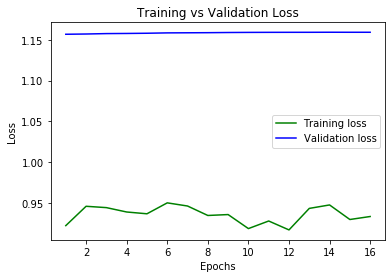

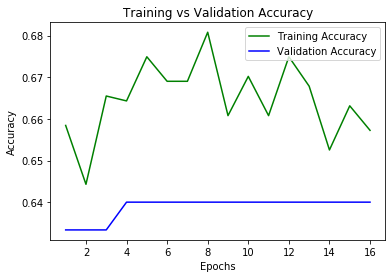

In [214]:
# Training and validation Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy for training and validation
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']

epochs = range(1,len(accuracy_train)+1)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')


plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [215]:
history = model_new.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[slower, stopper])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
107/107 [==============================] - 0s 3ms/step - loss: 0.9294 - accuracy: 0.6761 - val_loss: 1.1412 - val_accuracy: 0.6600
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 0.9082 - accuracy: 0.6714 - val_loss: 1.1433 - val_accuracy: 0.6533
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 0.9129 - accuracy

In [216]:
test_accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test Set Loss: ',test_accuracy[0])
print('Test Set Accuracy: ',test_accuracy[1])

Test Set Loss:  1.1412105560302734
Test Set Accuracy:  0.6600000262260437


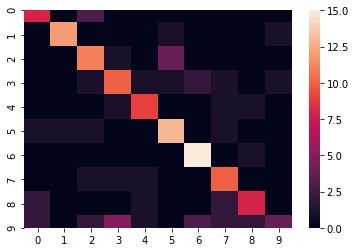

In [240]:
y_pred = model_new.predict(X_test)
sn.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

In [ ]:
for i in range(len(full_features[0])):
    print(data.columns[i], '\t\t\t', data.iloc[0, :-1][i], '\t\t\t', full_features[0][i])

In [265]:
model_new.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 64)                3584      
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 256)               16640     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 128)             

In [266]:
temp_weights = model_new.layers[-1].get_weights()
model_new.pop()
model_new.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 64)                3584      
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 256)               16640     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 128)             

In [254]:
temp_weights[1]

array([-0.04033614, -0.20154978,  0.15032396,  0.12740777, -0.04796507,
        0.00880126, -0.12001513, -0.14567745,  0.05018338,  0.1043717 ],
      dtype=float32)

In [267]:
model_new.add(Dense(10, activation='sigmoid'))
model_new.layers[-1].set_weights(temp_weights)
model_new.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 64)                3584      
_________________________________________________________________
dropout_113 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 256)               16640     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 128)             

In [275]:
# consider lowering smaple rate to speed up preprocessing

data, _ = lr.load('15 Ritchie Valens - La Bamba.wav')

features = []
genres = []

for index in range(0, len(data)-int(sample_size/2), int(sample_size/2)):

    cur_data = data[index:index+(sample_size)]
    
    c_s = lr.feature.chroma_stft(cur_data)
    features.append(np.mean(c_s))
    features.append(np.var(c_s))
    
    rms = lr.feature.rms(cur_data)
    features.append(np.mean(rms))
    features.append(np.var(rms))
    
    s_c = lr.feature.spectral_centroid(cur_data)
    features.append(np.mean(s_c))
    features.append(np.var(s_c))
    
    s_b = lr.feature.spectral_bandwidth(cur_data)
    features.append(np.mean(s_b))
    features.append(np.var(s_b))
    
    s_r = lr.feature.spectral_rolloff(cur_data)
    features.append(np.mean(s_r))
    features.append(np.var(s_r))
    
    z_c_r = lr.feature.zero_crossing_rate(cur_data)
    features.append(np.mean(z_c_r))
    features.append(np.var(z_c_r))
    
    harm = lr.effects.harmonic(cur_data)
    features.append(np.mean(harm))
    features.append(np.var(harm))
    
    features.append(lr.beat.tempo(cur_data))
    
    for n in range(1, 21):
        mfcc = lr.feature.mfcc(cur_data)
        features.append(np.mean(mfcc))
        features.append(np.var(mfcc))
    
    i = 0
    for row in metadata.iterrows():
        features[i] = (features[i] - row[1]['min']) / row[1]['dif']
        i += 1
    
    features = np.array(features, dtype=np.float)
    
    genres.append(model_new.predict(np.expand_dims(features,0)))
    
    features = []
    
genres = np.mean(np.squeeze(genres), axis=0)

In [276]:
pd.DataFrame(np.squeeze(genres))

,0
0,0.375
1,0.000
2,0.000
3,0.000
4,1.000
5,0.000
6,0.000
7,1.000
8,1.000
9,0.000


In [272]:
np.median(np.squeeze(genres), axis=0)

array([0.8651216 , 0.11944278, 0.43197435, 0.49026376, 0.14968775,
       0.07576361, 0.67587245, 0.0122446 , 0.19410905, 0.79520863],
      dtype=float32)

In [274]:
#model_new.save('best_model_relu.h5')

In [273]:
np.mean(np.squeeze(genres), axis=0)

array([0.7587962 , 0.11783997, 0.40073076, 0.5158082 , 0.24320555,
       0.07474166, 0.65497303, 0.05969401, 0.29874057, 0.75139284],
      dtype=float32)

In [ ]:
genre_map = ['hiphop', 'reggae', 'pop', 'blues', 'country','jazz', 'metal','disco','classical', 'rock']